We hypothesise that there will be two significant peaks in the greyscale intesity of the CT scans, due to edge effects: these will be at the boundary between air and the cementum, and at the cementum-dentine boundary.

To check this we will find 4 random images from 4 teeth, straighten them and plot the greyscale intensity along each row. Hopefully we will see these two peaks.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
"""
Choose an image to demonstrate with

"""
import os
import numpy as np


def paths(i: int):
    """Image and Mask path from an index"""
    rvs = f"data/original cut/{i:04d}.tif", f"data/masks cut/{i:04d}.tif"
    for path in rvs:
        assert os.path.exists(path), path

    return rvs


rng = np.random.default_rng()
index = rng.integers(0, 516)
img_path, mask_path = paths(index)

img_path, mask_path

('data/original cut/0222.tif', 'data/masks cut/0222.tif')

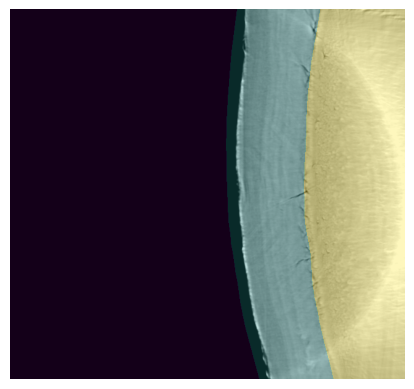

In [3]:
"""
Display it

"""
import matplotlib.pyplot as plt

fig, axis = plt.subplots()

img = plt.imread(img_path)
mask = plt.imread(mask_path)

axis.imshow(img, cmap="gray")
axis.imshow(mask, alpha=0.3)

axis.set_axis_off()

imgdir = f"img/detect_cementum/{index}/"
if not os.path.isdir(imgdir):
    os.makedirs(imgdir)

fig.savefig(f"{imgdir}/img_masks.png", bbox_inches="tight")

/home/mh19137/cementum/cementum/straighten.py:527: UserWarning: Temporary solution: removing 20 saturated columns from right
  warnings.warn(
/home/mh19137/cementum/cementum/straighten.py:553: UserWarning: Temporary solution: removing 18 zero rows from bottom
  warnings.warn(


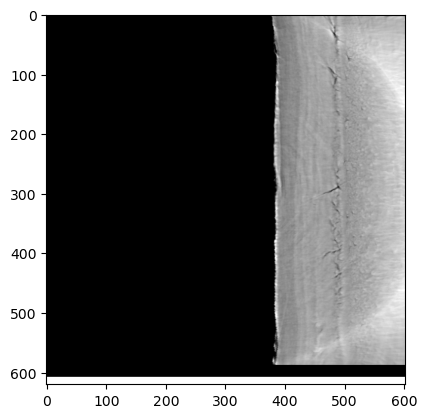

In [4]:
"""
Straighten these images according the the masks

"""
from cementum import straighten

n_y = 20
n_left, n_x, n_right = 5, 5, 5

fig, axis = plt.subplots()

# Define two grids of points that will we use to perform our straightening
curve_pts = straighten.mask_mesh(mask, n_y, (n_left, n_x, n_right))
straight_pts = straighten.straight_mesh(mask, n_y, (n_left, n_x, n_right))

# Straighten the image
img = plt.imread(img_path)
straight_image = straighten.apply_transformation(img, curve_pts, straight_pts)

# Straighten the mask
straight_mask = straighten.apply_transformation(mask, curve_pts, straight_pts)

# Remove the white columns from the image and the corresponding columns from the mask
straight_image, straight_mask = straighten.remove_white_cols(
    straight_image, straight_mask
)

# Remove padding
straight_image = straighten.remove_padding(straight_image)
straight_mask = straighten.remove_padding(straight_mask)


# Display it
axis.imshow(straight_image, cmap="gray")


fig.savefig(f"{imgdir}/straightened.png", bbox_inches="tight")

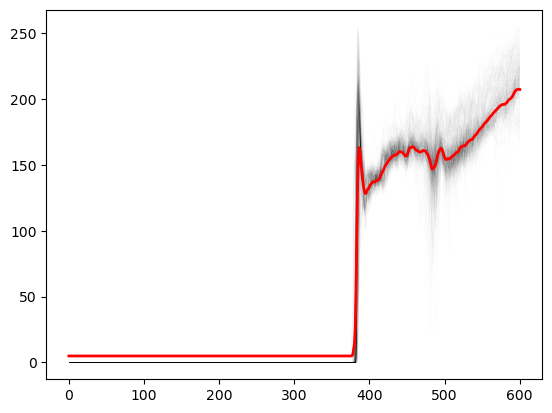

In [5]:
"""
Plot the greyscale intensity across each row for all of these images

"""
fig, axis = plt.subplots()

intensity_profile = np.mean(straight_image, axis=0)

for row in straight_image:
    axis.plot(row, alpha=0.05, linewidth=0.05, color="k")
axis.plot(intensity_profile, color="r", linewidth=2)

fig.savefig(f"{imgdir}/intensity.png", bbox_inches="tight")

  2%|▏         | 3/174 [00:00<00:22,  7.46it/s]

saving img/detect_cementum/222//anim/animation.mp4


 35%|███▌      | 61/174 [00:09<00:21,  5.19it/s]/home/mh19137/cementum/cementum/fit_cementum.py:271: UserWarning: Optimal parameters not found: The maximum number of function evaluations is exceeded.
  warnings.warn(util.coloured(e, util.bcolours.WARNING))
/home/mh19137/miniforge3/envs/tf2/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:1983: RuntimeWarning: divide by zero encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
/home/mh19137/miniforge3/envs/tf2/lib/python3.9/site-packages/scipy/stats/_distn_infrastructure.py:1983: RuntimeWarning: invalid value encountered in divide
  x = np.asarray((x - loc)/scale, dtype=dtyp)
 47%|████▋     | 82/174 [00:14<00:17,  5.24it/s]/home/mh19137/miniforge3/envs/tf2/lib/python3.9/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
177it [00:33,  5.13it/s]                         

24 [ 10.13995576  10.70018876   7.12211706   8.17991238 284.02011269
 836.48737777 268.72111141 285.35007686]
27 [ 10.13995576  10.70018876   7.12211706   8.17991238 284.02011269
 836.48737777 268.72111141 285.35007686]
41 [ 10.13995576  10.70018876   7.12211706   8.17991238 284.02011269
 836.48737777 268.72111141 285.35007686]
51 [ 10.13995576  10.70018876   7.12211706   8.17991238 284.02011269
 836.48737777 268.72111141 285.35007686]
61 [ 10.13995576  10.70018876   7.12211706   8.17991238 284.02011269
 836.48737777 268.72111141 285.35007686]
65 [ 10.13995576  10.70018876   7.12211706   8.17991238 284.02011269
 836.48737777 268.72111141 285.35007686]
71 [ 10.13995576  10.70018876   7.12211706   8.17991238 284.02011269
 836.48737777 268.72111141 285.35007686]
73 [ 10.13995576  10.70018876   7.12211706   8.17991238 284.02011269
 836.48737777 268.72111141 285.35007686]
img/detect_cementum/222/detection.png


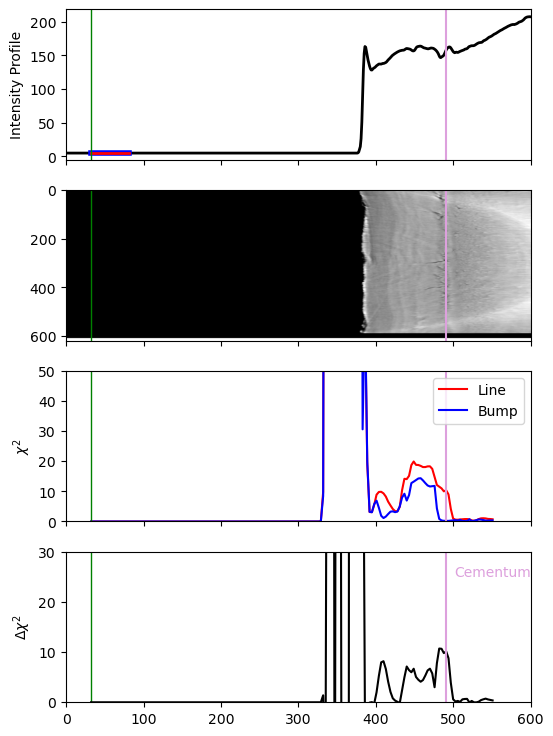

In [6]:
"""
Gif showing the fit process

"""
from matplotlib.animation import FuncAnimation
from tqdm import tqdm

from cementum import fit_cementum

# Fit params
domain_length = 50

# Peak detection params
tolerance = 7
rel_height = 0.99

fig, axes = plt.subplots(4, 1, figsize=(6, 9), sharex=True)

# Show the intensity profile and image
axes[0].plot(
    np.arange(straight_image.shape[1]), intensity_profile, color="k", linewidth=2
)
axes[1].imshow(straight_image, cmap="gray", aspect="auto")

axes[2].set_ylim((0, 50))
axes[3].set_ylim((0, 30))

offsets = np.arange(0, straight_image.shape[0] - 2 * domain_length, 3)

# Do one fit
line_params, line_chi2, line_x = fit_cementum.fit_line_restricted_domain(
    offsets[0], intensity_profile, n_pixels=domain_length
)
bump_params, bump_chi2, bump_x = fit_cementum.fit_line_with_bump_restricted_domain(
    offsets[0], intensity_profile, n_pixels=domain_length
)

assert (bump_x == line_x).all()
leftmost_points = [line_x.min()]

line_chi2s = [line_chi2]
bump_chi2s = [bump_chi2]

# Show the fits
(bump_line,) = axes[0].plot(
    bump_x,
    fit_cementum.line_with_bump(bump_x, *bump_params),
    "b",
    linewidth=4,
)
(fit_line,) = axes[0].plot(
    line_x,
    fit_cementum._line(line_x, *line_params),
    "r",
    linewidth=2,
)

# goodness of fits
(line_chi2_line,) = axes[2].plot(leftmost_points, line_chi2s, "-r", label="Line")
(bump_chi2_line,) = axes[2].plot(leftmost_points, bump_chi2s, "-b", label="Bump")

# Vertical lines tracking where we are
vlines = [axis.axvline(leftmost_points[-1], color="g", linewidth=1) for axis in axes]

# Delta Chi2
delta_chi2 = [line_chi2 - bump_chi2]
(delta_chi2_line,) = axes[3].plot(leftmost_points, delta_chi2, "-k", label="Delta Chi2")

# Progress bar
pbar = tqdm(total=len(offsets))


# Animation
def update_lines(offset):
    """
    Perform another fit and update the lines

    """
    global pbar

    # Re do fits
    line_params, line_chi2, line_x = fit_cementum.fit_line_restricted_domain(
        offset, intensity_profile, n_pixels=domain_length
    )
    (
        bump_params,
        bump_chi2,
        bump_x,
    ) = fit_cementum.fit_line_with_bump_restricted_domain(
        offset, intensity_profile, n_pixels=domain_length
    )

    # Update fit lines
    assert (line_x == bump_x).all()
    leftmost_points.append(line_x.min())
    fit_line.set_data(line_x, fit_cementum._line(line_x, *line_params))
    bump_line.set_data(bump_x, fit_cementum.line_with_bump(bump_x, *bump_params))

    # Update chi2 lines
    line_chi2s.append(line_chi2)
    bump_chi2s.append(bump_chi2)
    line_chi2_line.set_data(leftmost_points, line_chi2s)
    bump_chi2_line.set_data(leftmost_points, bump_chi2s)

    delta_chi2.append(line_chi2 - bump_chi2)
    delta_chi2_line.set_data(leftmost_points, delta_chi2)

    # Update vertical lines
    for line in vlines:
        line.set_data([leftmost_points[-1], leftmost_points[-1]], line.get_ydata())

    pbar.update(1)

    return fit_line, bump_line, line_chi2_line, bump_chi2_line, delta_chi2_line, *vlines


anim = FuncAnimation(
    fig,
    update_lines,
    frames=offsets,
    fargs=(),
    interval=30,
    blit=True,
)

axes[0].set_ylabel("Intensity Profile")
axes[2].legend()
axes[2].set_ylabel(r"$\chi^2$")
axes[3].set_ylabel(r"$\Delta\chi^2$")

anim_dir = f"{imgdir}/anim"
if not os.path.isdir(anim_dir):
    os.mkdir(anim_dir)

path = f"{anim_dir}/animation.mp4"
print(f"saving {path}")
anim.save(path)

# Detect the cementum peak, plot + save it
peak_location = fit_cementum.find_cementum(
    leftmost_points, delta_chi2, tolerance=tolerance, rel_height=1.0
)
for axis in axes:
    axis.axvline(peak_location, color="plum")

axes[3].text(peak_location + 10, 25, "Cementum", color="plum")
path = f"{imgdir}detection.png"
print(path)
fig.savefig(path, bbox_inches="tight")

In [7]:
d = np.array(delta_chi2)
l = np.array(leftmost_points)
for a, b in zip(d[d>5], l[d>5]):
    print(b, a)

494 8.77385518239411
491 10.139955759058756
488 9.79126199242061
485 10.651977142979346
482 10.700188757193756
479 7.787842094517381
473 5.741754367328058
470 6.693026445935132
467 6.3347235802940585
464 5.312451887248956
452 5.046472513697768
449 6.6805085627430465
446 5.976655087671899
443 6.391401883734961
440 7.122117063143256
413 6.641330013667511
410 8.179912376272114
407 7.95349837850417
404 5.251814981955711
383 83.43073908366352
380 284.0201126860722
374 722.0539850831545
371 812.4988498478908
368 836.4873777733992
353 209.3008210490791
350 268.72111140908214
344 285.35007685534856
341 235.51877491921414
338 143.228811296284
